ΑΡΧΟΝΤΉΣ ΝΕΣΤΩΡΑΣ ΑΜ:4747

# Ερώτηση 2
## Βήμα 1
Το παρακάτω block κώδικα   επεξεργάζεται το αρχείο 'meta_Cell_Phones_and_Accessories.json' έτσι ώστε να κρατήσω μόνο τα δεδομένα που χρειάζονται.

In [28]:
import pandas as pd
import json


json_file_path = 'meta_Cell_Phones_and_Accessories.json'
csv_file_path = 'output.csv'

asin_descriptions = {}

with open(json_file_path, 'r', encoding='utf-8') as json_file:
    for line in json_file:
        json_obj = json.loads(line)

        if (
            "category" in json_obj and
            "description" in json_obj and
            "asin" in json_obj and
            "Cell Phones & Accessories" in json_obj["category"] and
            ("Chargers & Power Adapters" in json_obj["category"][-1] or "Car Chargers" in json_obj["category"][-1]) and
            json_obj["description"] != []
        ):
            current_asin = json_obj["asin"]
            current_description = json_obj["description"]
            if current_asin in asin_descriptions:
                asin_descriptions[current_asin]["description"].extend(current_description)
            else:
                asin_descriptions[current_asin] = {
                    "category": json_obj.get("category"),
                    "description": current_description,
                }

df = pd.DataFrame(list(asin_descriptions.values()))
df['description'] = df['description'].apply(lambda x: [desc for desc in x if desc.strip()])

df.to_csv(csv_file_path, index=False)







## Βήμα 2
Στο παρακάτω block γίνεται shuffle στα δεδομένα και δημιουργουνται το 5 Fold που χρειάζονται. Στη συνέχεια υπάρχει μια μικρή επεξεργασία στα δεδομένα για να μπορούν να χρησιμοποιηθούν απο τις μεθόδους Logistic Regression, SVM, και Multi-Layer Perceptron. Χρησιμοποιείται η αναπαράσταση tf-idf για τις περιγραφές. Παρουσιάζονται επίσης κάποιες μετρικές για τις μεθόδους που χρησιμοποιήσαμε

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')


lr_accuracies = []
lr_reports = []

svm_accuracies = []
svm_reports = []

mlp_accuracies = []
mlp_reports = []

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)




kfold = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_sets = []
all_test_sets = []
fold_number=0

confusion_matrices_reg = []
accuracies_reg = []
precisions_reg = []
recalls_reg = []
f1_scores_reg = []


confusion_matrices_svl = []
accuracies_svl = []
precisions_svl = []
recalls_svl = []
f1_scores_svl = []

confusion_matrices_mlp = []
accuracies_mlp = []
precisions_mlp = []
recalls_mlp = []
f1_scores_mlp = []

for train_index, test_index in kfold.split(df_shuffled):
    train_set, test_set = df.iloc[train_index], df.iloc[test_index]

    tt = train_set['category'].tolist()
    tt2 = [sublist[-1] for sublist in tt]
    
    ttt = test_set['category'].tolist()
    ttt2 = [sublist[-1] for sublist in ttt]
    
    texts1 = train_set['description'].tolist()
    texts1_test = test_set['description'].tolist()
    
    texts1_2 = [item[0] if item else '' for item in texts1]
    texts1_2_test = [item[0] if item else '' for item in texts1_test]

    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    
    tfidf_vectorizer.fit(texts1_2)
    tfidf_matrix_train = tfidf_vectorizer.transform(texts1_2)
    tfidf_matrix_test = tfidf_vectorizer.transform(texts1_2_test)
    
    logistic_regression = LogisticRegression()
    logistic_regression.fit(tfidf_matrix_train,tt2)
    predictions_lr = logistic_regression.predict(tfidf_matrix_test)
    
    accuracy_lr = accuracy_score(ttt2, predictions_lr)

    #print(classification_report(ttt2, predictions_lr))
    prec_lr = precision_score(ttt2, predictions_lr, average=None)
    rec_lr = recall_score(ttt2, predictions_lr, average=None)
    f1_lr = f1_score(ttt2, predictions_lr, average=None)

    
    lr_accuracies.append(accuracy_lr)
    lr_reports.append(classification_report(ttt2, predictions_lr))
    
    svm_clf = SVC(kernel='linear')
    svm_clf.fit(tfidf_matrix_train,tt2)
    predictions_svm = svm_clf.predict(tfidf_matrix_test)
    accuracy_svm = accuracy_score(ttt2, predictions_svm)
    
    #print("SVM Classification Report:")
    #print(classification_report(ttt2, predictions_svm))
    prec_svm = precision_score(ttt2, predictions_svm, average=None)
    rec_svm = recall_score(ttt2, predictions_svm, average=None)
    f1_svm = f1_score(ttt2, predictions_svm, average=None)

    
    svm_accuracies.append(accuracy_svm)
    svm_reports.append(classification_report(ttt2, predictions_svm))

    mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000)
    mlp_clf.fit(tfidf_matrix_train,tt2)
    predictions_mlp = mlp_clf.predict(tfidf_matrix_test)
    
    accuracy_mlp = accuracy_score(ttt2, predictions_mlp)
    confusion_mlp = confusion_matrix(ttt2, predictions_mlp)
    prec_mlp = precision_score(ttt2, predictions_mlp, average=None)
    rec_mlp = recall_score(ttt2, predictions_mlp, average=None)
    f1_mlp = f1_score(ttt2, predictions_mlp, average=None)
    
 
    #print(classification_report(ttt2, predictions_mlp))
 
    
    mlp_accuracies.append(accuracy_mlp)
    confusion_matrices_mlp.append(confusion_mlp)
    precisions_mlp.append(prec_mlp)
    recalls_mlp.append(rec_mlp)
    f1_scores_mlp.append(f1_mlp)
    mlp_reports.append(classification_report(ttt2, predictions_mlp))
    
    fold_number = fold_number + 1








mean_accuracy_lr = np.mean(accuracy_lr)
mean_precision_lr = np.mean(prec_lr)
mean_recall_lr = np.mean(rec_lr)
mean_f1_score_lr = np.mean(f1_lr)


mean_accuracy_svm = np.mean(accuracy_svm)
mean_precision_svm = np.mean(prec_svm)
mean_recall_svm = np.mean(rec_svm)
mean_f1_score_svm = np.mean(f1_svm)


mean_accuracy_mlp = np.mean(accuracy_mlp)
mean_precision_mlp = np.mean(prec_mlp)
mean_recall_mlp = np.mean(rec_mlp)
mean_f1_score_mlp = np.mean(f1_mlp)

print("Logistic Regression:")
print("Mean Accuracy:", mean_accuracy_lr)
print("Mean Precision:", mean_precision_lr)
print("Mean Recall:", mean_recall_lr)
print("Mean F1 Score:", mean_f1_score_lr)

print("\nSVM:")
print("Mean Accuracy:", mean_accuracy_svm)
print("Mean Precision:", mean_precision_svm)
print("Mean Recall:", mean_recall_svm)
print("Mean F1 Score:", mean_f1_score_svm)

print("\nMLP:")
print("Mean Accuracy:", mean_accuracy_mlp)
print("Mean Precision:", mean_precision_mlp)
print("Mean Recall:", mean_recall_mlp)
print("Mean F1 Score:", mean_f1_score_mlp)








avg_lr_accuracy = sum(lr_accuracies) / len(lr_accuracies)
avg_svm_accuracy = sum(svm_accuracies) / len(svm_accuracies)
avg_mlp_accuracy = sum(mlp_accuracies) / len(mlp_accuracies)
print()
print(f"Average Logistic Regression Accuracy: {avg_lr_accuracy}")
print(f"Average SVM Accuracy: {avg_svm_accuracy}")
print(f"Average MLP Accuracy: {avg_mlp_accuracy}")








Logistic Regression:
Mean Accuracy: 0.8401142041399001
Mean Precision: 0.8303718511908847
Mean Recall: 0.8322017082218962
Mean F1 Score: 0.8312556458897924

SVM:
Mean Accuracy: 0.8458244111349036
Mean Precision: 0.8355638742948148
Mean Recall: 0.8435672073160211
Mean F1 Score: 0.8388729154686603

MLP:
Mean Accuracy: 0.8408279800142755
Mean Precision: 0.8314808348851646
Mean Recall: 0.8317153394875334
Mean F1 Score: 0.8315975974778153

Average Logistic Regression Accuracy: 0.827745211541379
Average SVM Accuracy: 0.826032454910442
Average MLP Accuracy: 0.8253191881486732


### Σχολιασμός των αποτελεσμάτων
Τα αποτελέσματα δείχνουν ικανοποιητική απόδοση των ταξινομητών στη κατηγοριοποίησης προϊόντων. Συγκεκριμένα:
Ακρίβεια (Precision): Η ακρίβεια για κάθε κατηγορία κυμαίνεται γύρω στο 0.8, που είναι αρκετά καλή. Αυτό σημαίνει ότι οι ταξινομητές είναι αποτελεσματικοί στο να μην ταξινομούν λανθασμένα ένα προϊόν σε μια κατηγορία όταν δεν ανήκει εκεί.
Ανάκληση (Recall): Η ανάκληση για κάθε κατηγορία επίσης είναι αρκετά υψηλή, κυμαινόμενη μεταξύ 0.7 και 0.9. Αυτό υποδεικνύει ότι οι ταξινομητές καταφέρνουν να εντοπίζουν σχεδόν όλα τα προϊόντα που πράγματι ανήκουν σε μια κατηγορία.
F1-Score: Το F1-Score εμφανίζει αξιόλογες τιμές, κοντά στο 0.81 για κάθε κατηγορία. Αυτό υποδεικνύει μια ισορροπημένη απόδοση των ταξινομητών σε όλες τις πτυχές της κατηγοριοποίησης.
Ακρίβεια Γενικής Κατηγοριοποίησης (Accuracy): Η μέση ακρίβεια για όλες τις κατηγορίες παρουσιάζει μια αξιοπρεπή απόδοση περίπου 0.82, η οποία είναι αρκετά ικανοποιητική. Αυτό υποδεικνύει ότι οι ταξινομητές είναι αρκετά αποτελεσματικοί στο σύνολο του προβλήματος.
Επομένως τα αποτελέσματα φαίνονται καλά και ότι οι ταξινομητές είναι αποτελεσματικοί.

Παρακάτω υπάρχει ο κώδικας που βρίσκει τις 20 λέξεις που ο classifier δίνει το μεγαλύτερο θετικό βάρος και τις 20 λέξεις με το μικρότερο αρνητικό βάρος.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logistic_regression.coef_[0]
word_coefficient_dict = dict(zip(feature_names, coefficients))

sorted_word_coefficients = sorted(word_coefficient_dict.items(), key=lambda x: x[1], reverse=True)

top_positive_words = sorted_word_coefficients[:20]

top_negative_words = sorted_word_coefficients[-20:]

print("Top 20 Positive Words:")
for word, coefficient in top_positive_words:
    print(word, ": ", coefficient)

print("\nTop 20 Negative Words:")
for word, coefficient in top_negative_words:
    print(word, ": ", coefficient)


Top 20 Positive Words:
wall :  6.1208397233516365
travel :  3.830823498769174
battery :  2.634907463231136
home :  2.632322159209832
extra :  2.4567236639784884
ac :  2.318390319508915
8a :  2.2151187375209154
desktop :  2.169758664699947
240v :  1.7921764152034116
qi :  1.7673588171157588
simply :  1.6652938746103727
station :  1.6414993541239684
sync :  1.6402388963500418
dock :  1.6225083496593666
60hz :  1.5955491110456201
nokia :  1.552587353462096
office :  1.4717381668672582
30 :  1.4248107302510042
100v :  1.408980838514596
receiver :  1.3572210293256306

Top 20 Negative Words:
range :  -1.3577538116466317
mount :  -1.4633903966604733
limited :  -1.4727605955708523
cars :  -1.475336093834142
hands :  -1.5313325595821328
button :  -1.5855433680414743
powered :  -1.6011289919582075
driving :  -1.663837757143118
auto :  -1.7899682986982888
12 :  -1.9346773000534847
dc :  -1.9428949476505684
do :  -2.011382329799527
dual :  -2.2440205516878495
24v :  -2.307114361563316
title :  -2.

# Βήμα 3

In [31]:
#3
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import numpy as np
import warnings
warnings.filterwarnings('ignore')





tt = train_set['category'].tolist()
tt2 = [sublist[-1] for sublist in tt]

ttt = test_set['category'].tolist()
ttt2 = [sublist[-1] for sublist in ttt]



texts1 = train_set['description'].tolist()
texts1_test = test_set['description'].tolist()

texts1_2 = [item[0] if item else '' for item in texts1]
texts1_2_test = [item[0] if item else '' for item in texts1_test]

documents = [TaggedDocument(words=word_list, tags=[i]) for i, word_list in enumerate(texts1_2)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)


embeddings = [doc2vec_model.dv[i] for i in range(len(documents))]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

accuracies_svm = []
precisions_svm = []
recalls_svm = []
f1_scores_svm = []

accuracies_mlp = []
precisions_mlp = []
recalls_mlp = []
f1_scores_mlp = []
for train_index, test_index in kfold.split(embeddings):
    X_train, X_test = np.array(embeddings)[train_index], np.array(embeddings)[test_index]
    y_train, y_test = np.array(tt2)[train_index], np.array(tt2)[test_index]



    
    tt = train_set['category'].tolist()
    tt2 = [sublist[-1] for sublist in tt]
    
    ttt = test_set['category'].tolist()
    ttt2 = [sublist[-1] for sublist in ttt]
    
    
    
    texts1 = train_set['description'].tolist()
    texts1_test = test_set['description'].tolist()
    
    texts1_2 = [item[0] if item else '' for item in texts1]
    texts1_2_test = [item[0] if item else '' for item in texts1_test]
    
    documents = [TaggedDocument(words=word_list, tags=[i]) for i, word_list in enumerate(texts1_2)]
    doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
    
    embeddings = [doc2vec_model.dv[i] for i in range(len(documents))]

    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)

    
    predictions = logistic_regression.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)



     # SVM
    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)
    predictions_svm = svm_classifier.predict(X_test)
     # Evaluation for SVM
    accuracy_svm = accuracy_score(y_test, predictions_svm)
    precision_svm = precision_score(y_test, predictions_svm, average='weighted')
    recall_svm = recall_score(y_test, predictions_svm, average='weighted')
    f1_svm = f1_score(y_test, predictions_svm, average='weighted')

    accuracies_svm.append(accuracy_svm)
    precisions_svm.append(precision_svm)
    recalls_svm.append(recall_svm)
    f1_scores_svm.append(f1_svm)
    
    # MLP
    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(X_train, y_train)
    predictions_mlp = mlp_classifier.predict(X_test)



     # Evaluation for MLP
    accuracy_mlp = accuracy_score(y_test, predictions_mlp)
    precision_mlp = precision_score(y_test, predictions_mlp, average='weighted')
    recall_mlp = recall_score(y_test, predictions_mlp, average='weighted')
    f1_mlp = f1_score(y_test, predictions_mlp, average='weighted')

    accuracies_mlp.append(accuracy_mlp)
    precisions_mlp.append(precision_mlp)
    recalls_mlp.append(recall_mlp)
    f1_scores_mlp.append(f1_mlp)
    
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)


mean_accuracy_lr = np.mean(accuracies)
mean_precision_lr = np.mean(precisions)
mean_recall_lr = np.mean(recalls)
mean_f1_score_lr = np.mean(f1_scores)

mean_accuracy_svm = np.mean(accuracies_svm)
mean_precision_svm = np.mean(precisions_svm)
mean_recall_svm = np.mean(recalls_svm)
mean_f1_score_svm = np.mean(f1_scores_svm)

mean_accuracy_mlp = np.mean(accuracies_mlp)
mean_precision_mlp = np.mean(precisions_mlp)
mean_recall_mlp = np.mean(recalls_mlp)
mean_f1_score_mlp = np.mean(f1_scores_mlp)

print("Logistic Regression:")
print("Mean Accuracy:", mean_accuracy_lr)
print("Mean Precision:", mean_precision_lr)
print("Mean Recall:", mean_recall_lr)
print("Mean F1 Score:", mean_f1_score_lr)

print("\nSVM:")
print("Mean Accuracy:", mean_accuracy_svm)
print("Mean Precision:", mean_precision_svm)
print("Mean Recall:", mean_recall_svm)
print("Mean F1 Score:", mean_f1_score_svm)

print("\nMLP:")
print("Mean Accuracy:", mean_accuracy_mlp)
print("Mean Precision:", mean_precision_mlp)
print("Mean Recall:", mean_recall_mlp)
print("Mean F1 Score:", mean_f1_score_mlp)

Logistic Regression:
Mean Accuracy: 0.6334330342306413
Mean Precision: 0.6213212204162746
Mean Recall: 0.6334330342306413
Mean F1 Score: 0.5887328131076307

SVM:
Mean Accuracy: 0.6569765981163368
Mean Precision: 0.6652364699942118
Mean Recall: 0.6569765981163368
Mean F1 Score: 0.6098667923138331

MLP:
Mean Accuracy: 0.666964974295614
Mean Precision: 0.6630482689185564
Mean Recall: 0.6669649742956139
Mean F1 Score: 0.6637263565887921


Παρατηρήσεις για το Doc2Vec model:
Ακρίβεια (Precision): Οι τιμές που παίρνει η Ακρίβεια κυμαίνονται από 0.614 μέχρι 0.66 ανάλογα τη μέθοδο που χρησιμοποιούμε. 
Ανάκληση (Recall):Οι τιμές που παίρνει η Ανάκληση κυμαίνονται από 0.58 μέχρι 0.66 ανάλογα τη μέθοδο που χρησιμοποιούμε.
F1-score:Οι τιμές που παίρνει το F1-score κυμαίνονται από 0.58 μέχρι 0.66 ανάλογα τη μέθοδο που χρησιμοποιούμε.

Τα αποτελέσματα είναι καλά καθώς η ακρίβεια που παίρνουμε ειναι πάνω απο 0.6 κατά μέσο όρο αλλά υπάρχει εμφανής πτώση της ποιότητας των αποτελεσμάτων σε σχέση με  tf-idf μοντέλο. Το  Doc2Vec είναι πιο σύνθετο μοντέλο σε σχέση με το  tf-idf και για αυτό το λόγο χρειάζεται περισσότερα δεδομένα. Έτσι λγω της ανεπάρκεις των δεδομένων το συγκεκριμένο μοντέλο δε πετυχαίνει τόσο καλά αποτελέσματα όσο το πρώτο.

# Βήμα 4

In [32]:
#4
from sklearn.model_selection import KFold
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np



 
tt = train_set['category'].tolist()
tt2 = [sublist[-1] for sublist in tt]

ttt = test_set['category'].tolist()
ttt2 = [sublist[-1] for sublist in ttt]

new_cat=df_shuffled['category'].tolist()
new_cat2= [sublist[-1] for sublist in new_cat]


texts1 = train_set['description'].tolist()
texts1_test = test_set['description'].tolist()
new_text=df_shuffled['description'].tolist()

texts1_2 = [item[0] if item else '' for item in texts1]
texts1_2_test = [item[0] if item else '' for item in texts1_test]
new_text2=[item[0] if item else '' for item in new_text]

documents = [TaggedDocument(words=word_list, tags=[i]) for i, word_list in enumerate(texts1_2)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)

embeddings = [doc2vec_model.dv[i] for i in range(len(documents))]
print(len(embeddings))
mean_embeddings = []


mean_embeddings = [np.mean(embedding, axis=0) for embedding in embeddings]




kfold = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies2 = []
precisions2 = []
recalls2 = []
f1_scores2 = []
accuracies_svm2 = []
precisions_svm2 = []
recalls_svm2 = []
f1_scores_svm2 = []

accuracies_mlp2 = []
precisions_mlp2 = []
recalls_mlp2 = []
f1_scores_mlp2 = []


mean_embeddings2 = [np.mean(embedding, axis=0) for embedding in embeddings]
for train_index, test_index in kfold.split(mean_embeddings):
    X_train, X_test = np.array(mean_embeddings)[train_index], np.array(mean_embeddings)[test_index]
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)
    y_train, y_test = np.array(tt2)[train_index], np.array(tt2)[test_index]



    
    tt = train_set['category'].tolist()
    tt2 = [sublist[-1] for sublist in tt]
    
    ttt = test_set['category'].tolist()
    ttt2 = [sublist[-1] for sublist in ttt]
    
    
    
    texts1 = train_set['description'].tolist()
    texts1_test = test_set['description'].tolist()
    
    texts1_2 = [item[0] if item else '' for item in texts1]
    texts1_2_test = [item[0] if item else '' for item in texts1_test]
    
   
    documents = [TaggedDocument(words=word_list, tags=[i]) for i, word_list in enumerate(texts1_2)]
    doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=4)
    
    embeddings = [doc2vec_model.dv[i] for i in range(len(documents))]
    
    mean_embeddings = []
    

    mean_embeddings = [np.mean(embedding, axis=0) for embedding in embeddings]
    logistic_regression = LogisticRegression()
    logistic_regression.fit(X_train, y_train)

    predictions = logistic_regression.predict(X_test)

    accuracy2 = accuracy_score(y_test, predictions)
    precision2 = precision_score(y_test, predictions, average='weighted')
    recall2 = recall_score(y_test, predictions, average='weighted')
    f12 = f1_score(y_test, predictions, average='weighted')

    accuracies2.append(accuracy2)
    precisions2.append(precision2)
    recalls2.append(recall2)
    f1_scores2.append(f12)



    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)
    predictions_svm = svm_classifier.predict(X_test)
    accuracy_svm2 = accuracy_score(y_test, predictions_svm)
    precision_svm2 = precision_score(y_test, predictions_svm, average='weighted')
    recall_svm2 = recall_score(y_test, predictions_svm, average='weighted')
    f1_svm2 = f1_score(y_test, predictions_svm, average='weighted')

    accuracies_svm2.append(accuracy_svm2)
    precisions_svm2.append(precision_svm2)
    recalls_svm2.append(recall_svm2)
    f1_scores_svm2.append(f1_svm2)
    
    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(X_train, y_train)
    predictions_mlp = mlp_classifier.predict(X_test)



    accuracy_mlp2 = accuracy_score(y_test, predictions_mlp)
    precision_mlp2 = precision_score(y_test, predictions_mlp, average='weighted')
    recall_mlp2 = recall_score(y_test, predictions_mlp, average='weighted')
    f1_mlp2 = f1_score(y_test, predictions_mlp, average='weighted')

    accuracies_mlp2.append(accuracy_mlp)
    precisions_mlp2.append(precision_mlp)
    recalls_mlp2.append(recall_mlp)
    f1_scores_mlp2.append(f1_mlp)
    
mean_accuracy = np.mean(accuracies2)
mean_precision = np.mean(precisions2)
mean_recall = np.mean(recalls2)
mean_f1_score = np.mean(f1_scores2)


mean_accuracy_lr = np.mean(accuracies2)
mean_precision_lr = np.mean(precisions2)
mean_recall_lr = np.mean(recalls2)
mean_f1_score_lr = np.mean(f1_scores2)

mean_accuracy_svm = np.mean(accuracies_svm2)
mean_precision_svm = np.mean(precisions_svm2)
mean_recall_svm = np.mean(recalls_svm2)
mean_f1_score_svm = np.mean(f1_scores_svm2)

mean_accuracy_mlp = np.mean(accuracies_mlp2)
mean_precision_mlp = np.mean(precisions_mlp2)
mean_recall_mlp = np.mean(recalls_mlp2)
mean_f1_score_mlp = np.mean(f1_scores_mlp2)

print("Logistic Regression:")
print("Mean Accuracy:", mean_accuracy_lr)
print("Mean Precision:", mean_precision_lr)
print("Mean Recall:", mean_recall_lr)
print("Mean F1 Score:", mean_f1_score_lr)

print("\nSVM:")
print("Mean Accuracy:", mean_accuracy_svm)
print("Mean Precision:", mean_precision_svm)
print("Mean Recall:", mean_recall_svm)
print("Mean F1 Score:", mean_f1_score_svm)

print("\nMLP:")
print("Mean Accuracy:", mean_accuracy_mlp)
print("Mean Precision:", mean_precision_mlp)
print("Mean Recall:", mean_recall_mlp)
print("Mean F1 Score:", mean_f1_score_mlp)


5606
Logistic Regression:
Mean Accuracy: 0.602571710705205
Mean Precision: 0.3633191842498821
Mean Recall: 0.602571710705205
Mean F1 Score: 0.453247637727729

SVM:
Mean Accuracy: 0.6009663195421708
Mean Precision: 0.5377726507692813
Mean Recall: 0.6009663195421708
Mean F1 Score: 0.4562790573632262

MLP:
Mean Accuracy: 0.6735057983942908
Mean Precision: 0.6695653238237795
Mean Recall: 0.6735057983942908
Mean F1 Score: 0.670060901692


Παρατηρήσεις για το Doc2Vec model χρησιμοποιώντας τη μέση τιμή των embeddings:
Ακρίβεια (Precision): Οι τιμές που παίρνει η Ακρίβεια κυμαίνονται από 0.34 μέχρι 0.50 ανάλογα τη μέθοδο που χρησιμοποιούμε. 
Ανάκληση (Recall):Οι τιμές που παίρνει η Ανάκληση κυμαίνονται από 0.58 μέχρι 0.60 ανάλογα τη μέθοδο που χρησιμοποιούμε.
F1-score:Οι τιμές που παίρνει το F1-score κυμαίνονται από 0.43 μέχρι 0.47 ανάλογα τη μέθοδο που χρησιμοποιούμε.
Παρατήρηση: Αυτή η μέθοδος έχει τα χειρότερα αποτελέσματα σε σχέση με τις προηγούμενες. Ένας από τους λόγους που συμβαίνει αυτό είναι η ελλειψη δεδομένων όπως αναφέρθηκε και πιο πάνω. Ένας άλλος λόγος είναι οι διάφοροι παράμετροι που μπορουν να χρησιμοποιηθούν οι οποίοι θα μπορούσαν να βελτιώσουν και τα αποτελέσματα.

# Ερώτηση 3


Στο παρακάτω block διαβάζονται τα δεδομένα απο τα αρχεία και εκπαιδεύονται κατάλληλα.

Number of nodes: 658
Number of edges: 2941

Mean Reciprocal Rank (MRR): 0.13500998174338916
HR@1: 0.06636155606407322
HR@2: 0.11212814645308924
HR@3: 0.13958810068649885
HR@4: 0.15102974828375287
HR@5: 0.17620137299771166
HR@6: 0.1945080091533181
HR@7: 0.21052631578947367
HR@8: 0.2219679633867277
HR@9: 0.23569794050343248
HR@10: 0.2562929061784897
HR@11: 0.2700228832951945
HR@12: 0.2768878718535469
HR@13: 0.2906178489702517
HR@14: 0.2997711670480549
HR@15: 0.32036613272311215
HR@16: 0.3318077803203661
HR@17: 0.3340961098398169
HR@18: 0.33867276887871856
HR@19: 0.34553775743707094
HR@20: 0.36155606407322655


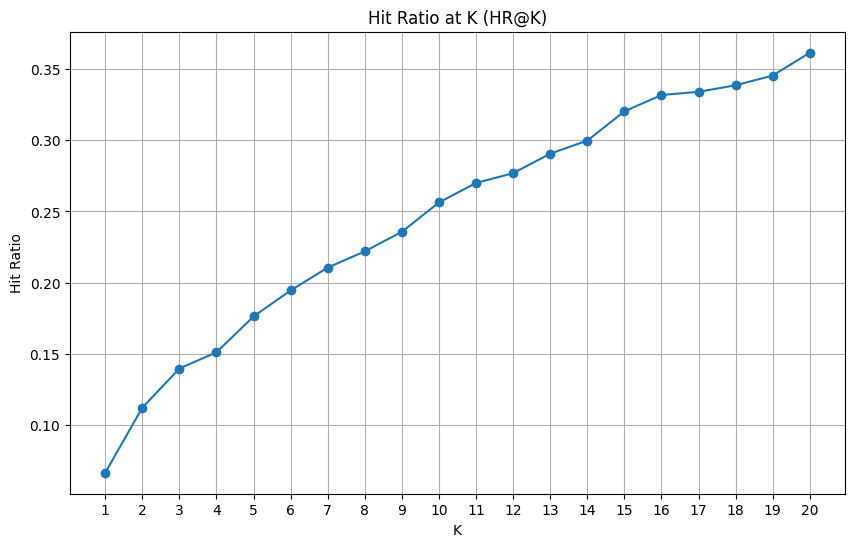

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt



train_data = pd.read_csv("graph_train_data.txt", sep=" ", header=None, names=["reviewerID", "asin"])

G = nx.Graph()

for _, row in train_data.iterrows():
    G.add_edge(row["reviewerID"], row["asin"])

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
user_purchases2 = set(train_data["reviewerID"])
test_data = pd.read_csv("graph_test_data.txt", sep=" ", header=None, names=["reviewerID", "asin"])
count=0
positions2 = []
for _, row in test_data.iterrows():
    G_personalized = nx.Graph()
    for product in G.neighbors(row["reviewerID"]):
        if product != row["asin"]:
            G_personalized.add_edge(row["reviewerID"], product)
    
    personalized_pagerank = nx.pagerank(G, personalization={row["reviewerID"]: 1})

    
    ranking = dict(sorted(personalized_pagerank.items(), key=lambda item: item[1], reverse=True))
    ranking = {k: v for k, v in ranking.items() if k not in user_purchases2}
    ranking = {k: v for k, v in ranking.items() if k not in  G.neighbors(row["reviewerID"])}
    user_purchases = set(G[row["asin"]])

    
    filtered_ranking = [product for product in ranking if product not in user_purchases2]
    
   

    if row["asin"] in ranking:
        position = list(ranking.keys()).index(row["asin"]) + 1
    else:
        position = -1
    
    positions2.append(position)

print()


def calculate_mrr(positions):
    reciprocal_ranks = [1 / position if position != -1 else 0 for position in positions]
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr

mrr = calculate_mrr(positions2)
print("Mean Reciprocal Rank (MRR):", mrr)


def calculate_hr_at_k(positions, k):
    hits = [1 if position != -1 and position <= k else 0 for position in positions]
    hr_at_k = sum(hits) / len(hits)
    return hr_at_k

k_values = list(range(1, 21))
hr_at_k_values = [calculate_hr_at_k(positions2, k) for k in k_values]

for k, hr_at_k in zip(k_values, hr_at_k_values):
    print(f"HR@{k}:", hr_at_k)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(k_values, hr_at_k_values, marker='o', linestyle='-')
plt.title('Hit Ratio at K (HR@K)')
plt.xlabel('K')
plt.ylabel('Hit Ratio')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()



## Αξιολόγηση αποτελεσμάτων
Για την τιμή MRR: Η τιμή MRR είναι 0.135 δείχνει τη μέση αντίστροφη θέση όπου βρίσκεται το στοιχείο που αναζητούμε. Αυτό σημαίνει ότι μέσα στο σύνολο δεδομένων που χρησιμοποιήθηκαν το επιθυμητό προϊόν κατά μέσο όρο στην 7η θέση του ranking
Για το HR: To Hit Ratio δείχνει πόσες φορές το επιθυμητό προιόν βρέθηκε στις K θέσεις του ranking. Όταν τρέχει για Κ=1 μεχρι Κ=20 βλέπουμε ότι παίρνει καλές τιμές. Στο Κ=20 έχει και το καλύτερο αποτέλεσμα 0.36155606407322655 το οποίο είναι λογικό καθώς έχει και περισσότερες θέσεις.

Φαίνεται έτσι πως ο αλγόριθμος δινει σχετικά καλά αποτελέσματα για την αγοραστική συμπεριφορά των χρηστών με βάση το προηγούμενο ιστορικό τους.